## Part 1: Heterogenous treatment effects using causal trees and forests

1.1 Load the data

In [16]:
data = read.csv('../data/experimental/experimental_control.csv')
head(data)

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,37,11,1,0,1,1,0,0,9930.0459
2,1,22,9,0,1,0,1,0,0,3595.8940
3,1,30,12,1,0,0,0,0,0,24909.4492
4,1,27,11,1,0,0,1,0,0,7506.1460
5,1,33,8,1,0,0,1,0,0,289.7899
6,1,22,9,1,0,0,1,0,0,4056.4939


1.2 Find the ATE

In [17]:
model <- lm(re78 ~ treat, data = data)

summary(model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),4554.801,408.0459,11.162474,1.154114e-25
treat,1794.342,632.8534,2.835321,4.787530e-03


Participation in the National Supported Work Demonstration Job Training Program increases real earnings by $1 794 on average.

1.3 Heterogenous effects with causal trees

In [18]:
vars = names(data)[names(data) != "re78" & names(data) != "treat"]

In [19]:
library(fastDummies)
X <- data[,vars]
Y <- data[, 're78']
W <- data[, 'treat']

In [39]:
library(grf)
library(DiagrammeR)
tree_model <- causal_forest(X, Y, W, num.trees = 1,
                      mtry = ncol(X))

Warning message:
"package 'DiagrammeR' was built under R version 4.3.3"


In [44]:
get_tree(tree_model, 1)

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: age  split_value: 24 
  (2) split_variable: age  split_value: 20 
    (4) split_variable: black  split_value: 0 
      (8) * num_samples: 5  avg_Y: 3871.11 avg_W: 0.2 
      (9) * num_samples: 29  avg_Y: 5348.74 avg_W: 0.31 
    (5) split_variable: age  split_value: 22 
      (10) * num_samples: 8  avg_Y: 7842.78 avg_W: 0.5 
      (11) * num_samples: 11  avg_Y: 4583.13 avg_W: 0.36 
  (3) split_variable: re74  split_value: 3472.95 
    (6) split_variable: educ  split_value: 10 
      (12) * num_samples: 27  avg_Y: 3810.19 avg_W: 0.33 
      (13) * num_samples: 24  avg_Y: 7521.07 avg_W: 0.46 
    (7) * num_samples: 7  avg_Y: 2880.37 avg_W: 0.57 

The interpretation is subject to the depth your tree ends up with. As specified in the issue, we would stick to what we saw in class (that is, an arbitrarily small tree). However, do not forget that a proper way to tune hyperparameters is Cross-Validation.

1.4 Heterogenous effects with causal forests

In [45]:
forest_model <- causal_forest(X, Y, W, num.trees = 200,
                      mtry = ncol(X))

In [48]:
varimp <- variable_importance(forest_model)
ranked.vars <- order(varimp, decreasing = TRUE)
importances <- data.frame(variable = colnames(X)[ranked.vars], importance = varimp[ranked.vars])
importances

variable,importance
<chr>,<dbl>
age,0.2970174982
re74,0.2298397132
educ,0.1688179702
re75,0.1571570455
nodegree,0.0725899048
marr,0.0653107279
black,0.0084661825
hisp,0.0008009576


In [49]:
get_tree(forest_model, 1)

GRF tree object 
Number of training samples: 222 
Variable splits: 
(1) split_variable: marr  split_value: 0 
  (2) split_variable: educ  split_value: 11 
    (4) split_variable: age  split_value: 25 
      (8) split_variable: educ  split_value: 9 
        (12) * num_samples: 22  avg_Y: 4694.46 avg_W: 0.45 
        (13) * num_samples: 30  avg_Y: 5717.47 avg_W: 0.3 
      (9) * num_samples: 19  avg_Y: 8172.79 avg_W: 0.37 
    (5) split_variable: re75  split_value: 0 
      (10) * num_samples: 17  avg_Y: 8068.89 avg_W: 0.71 
      (11) * num_samples: 6  avg_Y: 3774.12 avg_W: 0.5 
  (3) split_variable: re75  split_value: 0 
    (6) * num_samples: 10  avg_Y: 5356.68 avg_W: 0.5 
    (7) * num_samples: 7  avg_Y: 6270.36 avg_W: 0.57 

1.5 Plot heterogenous effects

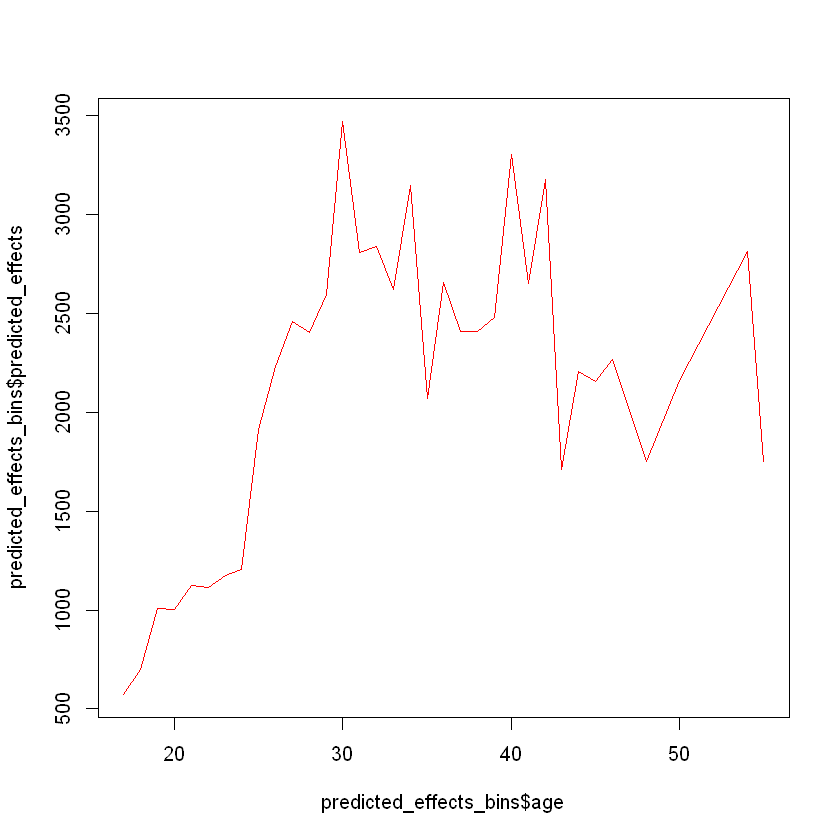

In [54]:
data$predicted_effects <- predict(forest_model, X)$predictions
predicted_effects_bins <- aggregate(predicted_effects ~ age, data = data, mean)
plot(predicted_effects_bins$age, predicted_effects_bins$predicted_effects, col = "red", type = 'l')

## Part 2: Double/Debiased machine learning in obsevational data

2.1 Load the data

In [70]:
data = read.csv('../data/observational/biased_control.csv')
head(data)

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,0,45,11,0,0,1,1,21.516670,25.243551,25.564670,2025,91125,121,0,0,236.68337,462.967085,637.23686
2,0,21,14,0,0,0,0,3.175971,5.852565,13.496080,441,9261,196,0,0,44.46359,10.086791,34.25252
3,0,38,12,0,0,1,0,23.039020,25.130760,25.564670,1444,54872,144,0,0,276.46823,530.796421,631.55509
4,0,48,6,0,0,1,1,24.994369,25.243551,25.564670,2304,110592,36,0,0,149.96621,624.718489,637.23686
5,0,18,8,0,0,1,1,1.669295,10.727610,9.860869,324,5832,64,0,0,13.35436,2.786546,115.08162
6,0,22,11,0,0,1,1,16.365760,18.449270,25.564670,484,10648,121,0,0,180.02336,267.838093,340.37555


2.2 Group comparisons

In [57]:
control <- data[data$treat == 0, ]
treated <- data[data$treat == 1, ]

In [58]:
summary(control)

     treat        age             educ           black        
 Min.   :0   Min.   :16.00   Min.   : 0.00   Min.   :0.00000  
 1st Qu.:0   1st Qu.:24.00   1st Qu.:11.00   1st Qu.:0.00000  
 Median :0   Median :31.00   Median :12.00   Median :0.00000  
 Mean   :0   Mean   :33.23   Mean   :12.03   Mean   :0.07354  
 3rd Qu.:0   3rd Qu.:42.00   3rd Qu.:13.00   3rd Qu.:0.00000  
 Max.   :0   Max.   :55.00   Max.   :18.00   Max.   :1.00000  
      hisp              marr           nodegree           re74       
 Min.   :0.00000   Min.   :0.0000   Min.   :0.0000   Min.   : 0.000  
 1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 4.403  
 Median :0.00000   Median :1.0000   Median :0.0000   Median :15.124  
 Mean   :0.07204   Mean   :0.7117   Mean   :0.2958   Mean   :14.017  
 3rd Qu.:0.00000   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:23.584  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.0000   Max.   :25.862  
      re75             re78            agesq         agecube      
 M

In [59]:
summary(treated)

     treat        age             educ           black             hisp        
 Min.   :1   Min.   :17.00   Min.   : 4.00   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:1   1st Qu.:20.00   1st Qu.: 9.00   1st Qu.:1.0000   1st Qu.:0.00000  
 Median :1   Median :25.00   Median :11.00   Median :1.0000   Median :0.00000  
 Mean   :1   Mean   :25.82   Mean   :10.35   Mean   :0.8432   Mean   :0.05946  
 3rd Qu.:1   3rd Qu.:29.00   3rd Qu.:12.00   3rd Qu.:1.0000   3rd Qu.:0.00000  
 Max.   :1   Max.   :48.00   Max.   :16.00   Max.   :1.0000   Max.   :1.00000  
      marr           nodegree           re74             re75       
 Min.   :0.0000   Min.   :0.0000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.000   1st Qu.: 0.000  
 Median :0.0000   Median :1.0000   Median : 0.000   Median : 0.000  
 Mean   :0.1892   Mean   :0.7081   Mean   : 2.096   Mean   : 1.532  
 3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.: 1.291   3rd Qu.: 1.817  
 Max.   :1.0000   Max.   :

The first thing to notice in the observational dataset is that the treated are significantly less than the controls. Among the features, age shows a clear difference of nearly 10 years on average between groups. The same can be said from de real income, with an average difference between groups of around $8 000 dollars. And so on.

As stated in the issue, the treatment and the control groups are not comparable. Therefore, these differences may be significant.

2.3 Compute the SMD

In [60]:
model <- lm(re78 ~ treat, data = data)

summary(model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),14.846660,0.07614292,194.98412,0.000000e+00
treat,-8.497516,0.71202072,-11.93437,1.074803e-32


Unlike the controlled experiment, this result tells us that participation in the National Supported Work Demonstration Job Training Program reduces real earnings by $8 498 on average; this shows the clear bias due to the lack of a proper control group. 

2.4 Using DML

DoubleML is an easy to use tool for DML. It's usage is pretty straight-forward and can be easily implemented by reading the [documentation](https://docs.doubleml.org/stable/intro/intro.html)

In [62]:
# install.packages("DoubleML")

In [71]:
X = names(data)[names(data) != "re78" & names(data) != "treat"]

In [72]:
# pip install -U DoubleML
library(DoubleML)

dml_data = DoubleMLData$new(data2,
                            y_col = 're78',
                            d_cols = 'treat',
                            x_cols = X)
print(dml_data)

================= DoubleMLData Object ==================


------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): treat
Covariates: age, educ, black, hisp, marr, nodegree, re74, re75, agesq, agecube, educsq, u74, u75, interaction1, re74sq, re75sq
Instrument(s): 
No. Observations: 16177


We will implement the learners saw in class: OLS, Lasso, Random trees and Random Forest

In [80]:
# install.packages("mlr3")
# install.packages("mlr3learners")
# install.packages("ranger")

In [81]:
library(mlr3)
library(mlr3learners)
lgr::get_logger("mlr3")$set_threshold("warn")


l_OLS = lrn("regr.lm")
l_lasso = lrn("regr.cv_glmnet", s="lambda.min")
l_RT = lrn("regr.ranger", num.trees=1)
l_RF = lrn("regr.ranger", num.trees=500)


In [89]:
DML_ols = DoubleMLPLR$new(dml_data, l_OLS, l_OLS)
DML_ols$fit()

In [91]:
DML_lasso = DoubleMLPLR$new(dml_data, l_lasso, l_lasso)
DML_lasso$fit()

In [97]:
DML_RT = DoubleMLPLR$new(dml_data, l_RT, l_RT)
DML_RT$fit()

In [98]:
DML_RF = DoubleMLPLR$new(dml_data, l_RF, l_RF)
DML_RF$fit()

In [94]:
print(DML_ols)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): treat
Covariates: age, educ, black, hisp, marr, nodegree, re74, re75, agesq, agecube, educsq, u74, u75, interaction1, re74sq, re75sq
Instrument(s): 
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_l: regr.lm
ml_m: regr.lm

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
      Estimate. Std. Error t value Pr(>|t|)  
treat    1.5636     0.6265   2.496   0.0126 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [95]:
print(DML_lasso)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): treat
Covariates: age, educ, black, hisp, marr, nodegree, re74, re75, agesq, agecube, educsq, u74, u75, interaction1, re74sq, re75sq
Instrument(s): 
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_l: regr.cv_glmnet
ml_m: regr.cv_glmnet

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
      Estimate. Std. Error t value Pr(>|t|)  
treat    1.4840     0.6272   2.366    0.018 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [99]:
print(DML_RT)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): treat
Covariates: age, educ, black, hisp, marr, nodegree, re74, re75, agesq, agecube, educsq, u74, u75, interaction1, re74sq, re75sq
Instrument(s): 
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_l: regr.ranger
ml_m: regr.ranger

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
      Estimate. Std. Error t value Pr(>|t|)  
treat    1.4596     0.6507   2.243   0.0249 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [100]:
print(DML_RF)

================= DoubleMLPLR Object ==================


------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): treat
Covariates: age, educ, black, hisp, marr, nodegree, re74, re75, agesq, agecube, educsq, u74, u75, interaction1, re74sq, re75sq
Instrument(s): 
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_l: regr.ranger
ml_m: regr.ranger

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: TRUE

------------------ Fit summary       ------------------
 Estimates and significance testing of the effect of target variables
      Estimate. Std. Error t value Pr(>|t|)
treat    1.0123     0.6928   1.461    0.144


